# Phase sensitivity

In this tutorial, we will use the summary data from the phase sensitivity analysis of 5,785 family trios with exome sequencing data and 635 family trios with whole genome sequencing data that largely overlapped with the gnomAD 2.1 release data.
Although this section is done using hail and hadoop, none of the work are actually using cloud computation. 

Although the part that actually extract the phase information from trio data is not included in this tutorial, you can find the relevant script in the `code` directory ( `sensitivity_proband_full.py` ).


## Loading the summary data

In [4]:
import hail as hl
import hail.expr.aggregators as agg
from typing import *
import pandas as pd

#genome
with hl.hadoop_open("gs://gnomad-qingbowang/MNV/phase_sensitivity_genome_proband_w100.tsv", 'r') as f:
        d_gen = pd.read_csv(f, sep="\t")
d_gen.fillna(0, inplace=True)
d_gen.index = d_gen.categ
del d_gen['categ']
del d_gen['0']
#exome
with hl.hadoop_open("gs://gnomad-qingbowang/MNV/phase_sensitivity_exome_proband_w100.tsv", 'r') as f:
        d_ex = pd.read_csv(f, sep="\t")
d_ex.fillna(0, inplace=True)
d_ex.index = d_ex.categ
del d_ex['categ']
del d_ex['0']


In [5]:
display(d_gen.head())
display(d_ex.head())

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
categ,,,,,,,,,,,,,,,,,,,,,
n_all,15910983,10765039,8016275,9417472,7702738,7818655,7065882,7529035,6856601,6790274,...,4778299,4799440,4765326,4779795,4782805,4861352,4759055,4794951,4750175,4754207
n_has_PBT,8647090,5464182,3908496,4566471,3648081,3716850,3350253,3598864,3261445,3224469,...,2402313,2385951,2372409,2387218,2373595,2427179,2376315,2381851,2368329,2371470
n_agrees_PBT,7831897,4423084,3466934,3776076,3244900,3196938,2972876,3094817,2883668,2819600,...,198833,191316,188947,197259,192329,201230,189531,190740,198933,187981
n_phased,13676712,8330084,6709002,7426737,6452657,6352604,5916878,6118333,5710902,5593119,...,934120,948456,937030,952331,953789,954926,927083,941005,944880,920321
n_phased_and_has_PBT,7863589,4450007,3487866,3801400,3263592,3219284,2989860,3116411,2899514,2837018,...,213371,204568,203238,212460,208011,216735,205378,205940,214066,202790


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
categ,,,,,,,,,,,,,,,,,,,,,
n_all,1245684,597400,658638,648295,552761,662307,503344,436542,538162,424871,...,231095,203396,255114,229720,226574,251263,203817,244578,238694,212742
n_has_PBT,748658,326701,350040,314760,279108,334035,250074,200045,277103,215659,...,110805,110720,133397,116933,122056,137960,100571,114896,127940,104608
n_agrees_PBT,680887,289375,317314,278473,253445,301448,218114,172187,245523,190164,...,2877,5445,7398,5721,4762,6090,6039,4037,6569,4449
n_phased,1082744,509467,565955,542130,492545,565080,405609,349056,447016,351213,...,32158,21917,25808,19587,26304,24087,32043,40566,44962,20002
n_phased_and_has_PBT,684246,290987,320343,280734,255777,302751,220910,173867,247292,192097,...,3706,6286,8646,6183,5312,6854,6819,4949,8003,5628


The row are different categories of phase, and columns are the distance between two heterozygous SNP pairs. 

(e.g. `n_has_PBT` is the number of variant pairs that both has phase information assigned by phase by transmission (PBT))

(Supplementary table 1)

It might be easier to see with the fraction, rather than the number of variant itself:

In [8]:
#fraction of MNV identified by read based phasing that agrees with PBT results
d_frac = pd.DataFrame({"exome (5,785 offsprings)":d_ex.loc["n_mnv_and_agrees_PBT",:]/d_ex.loc["n_mnv_and_has_PBT",:]})
d_frac["genome (635 offsprings)"] = d_gen.loc["n_mnv_and_agrees_PBT",:]/d_gen.loc["n_mnv_and_has_PBT",:]
d_frac.fillna(0, inplace=True)
display(d_frac.transpose())

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
"exome (5,785 offsprings)",0.997679,0.998695,0.996412,0.996760,0.995457,0.998106,0.995282,0.997555,0.998765,0.998066,...,0.867257,0.844156,0.942249,0.943633,0.956159,0.925602,0.932692,0.857585,0.646809,0.545852
genome (635 offsprings),0.998759,0.998154,0.998343,0.998057,0.998211,0.997694,0.998215,0.998036,0.998410,0.998231,...,0.961292,0.963508,0.952833,0.958753,0.956397,0.959761,0.960056,0.951062,0.954722,0.950084


and it is always easier to visualize:
(Supplementary Fig. 1)

<Figure size 576x360 with 0 Axes>

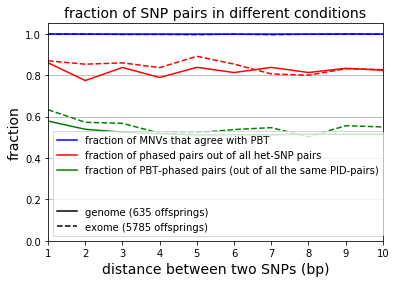

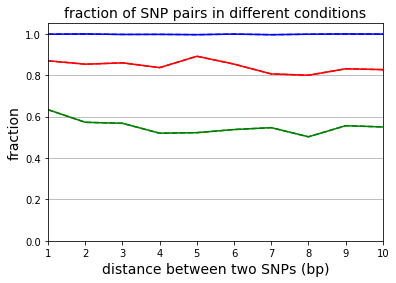

In [11]:
%matplotlib inline
import matplotlib
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = "1"
legend_elements = [Line2D([0], [0], color='b', label='fraction of MNVs that agree with PBT'),
                   Line2D([0], [0], color='r', label='fraction of phased pairs out of all het-SNP pairs'),
                   Line2D([0], [0], color='g', label='fraction of PBT-phased pairs (out of all the same PID-pairs)'),
                   Line2D([0], [0], color="#ffffffff", label='\n'),
                   Line2D([0], [0], color='black', label='genome (635 offsprings)'),
                   Line2D([0], [0], color='black', linestyle="dashed", label='exome (5785 offsprings)'),
                          ]
d_frac = pd.DataFrame({"fraction of phased pairs":d_gen.loc["n_phased",:]/d_gen.loc["n_all",:]})
d_frac["fraction of PBT-phased pairs (out of all the same PID-pairs)"] = d_gen.loc["n_same_PID_and_has_PBT",:]/d_gen.loc["n_same_PID",:]
d_frac["fraction of MNV that agrees with PBT"] = d_gen.loc["n_mnv_and_agrees_PBT",:]/d_gen.loc["n_mnv_and_has_PBT",:]
ax = d_frac.plot(ylim=[0,1.05], xlim=[0,9],color=["r","g","b"], legend=False)
ax.set_xlabel("distance between two SNPs (bp)", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_ylabel("fraction", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_title("fraction of SNP pairs in different conditions", fontname = "Microsoft Sans Serif", fontsize=14)
d_frac = pd.DataFrame({"fraction of phased pairs":d_ex.loc["n_phased",:]/d_ex.loc["n_all",:]})
d_frac["fraction of PBT-phased pairs (out of all the same PID-pairs)"] = d_ex.loc["n_same_PID_and_has_PBT",:]/d_ex.loc["n_same_PID",:]
d_frac["fraction of MNV that agrees with PBT"] = d_ex.loc["n_mnv_and_agrees_PBT",:]/d_ex.loc["n_mnv_and_has_PBT",:]
d_frac.plot(ylim=[0,1.05], xlim=[0,9], ax=ax, linestyle="dashed", color=["r","g","b"], legend=False) 
ax.legend(handles=legend_elements)
plt.grid(axis='y', which="both")
plt.show()

#one more without legend
ax = d_frac.plot(ylim=[0,1.05], xlim=[0,9],color=["r","g","b"], legend=False)
ax.set_xlabel("distance between two SNPs (bp)", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_ylabel("fraction", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_title("fraction of SNP pairs in different conditions", fontname = "Microsoft Sans Serif", fontsize=14)
d_frac = pd.DataFrame({"fraction of phased pairs":d_ex.loc["n_phased",:]/d_ex.loc["n_all",:]})
d_frac["fraction of PBT-phased pairs (out of all the same PID-pairs)"] = d_ex.loc["n_same_PID_and_has_PBT",:]/d_ex.loc["n_same_PID",:]
d_frac["fraction of MNV that agrees with PBT"] = d_ex.loc["n_mnv_and_agrees_PBT",:]/d_ex.loc["n_mnv_and_has_PBT",:]
d_frac.plot(ylim=[0,1.05], xlim=[0,9], ax=ax, linestyle="dashed", color=["r","g","b"], legend=False) 
#ax.legend(handles=legend_elements)
plt.grid(axis='y', which="both")
plt.show()

Coming back to the number itself:
(Supp. Fig. 1)

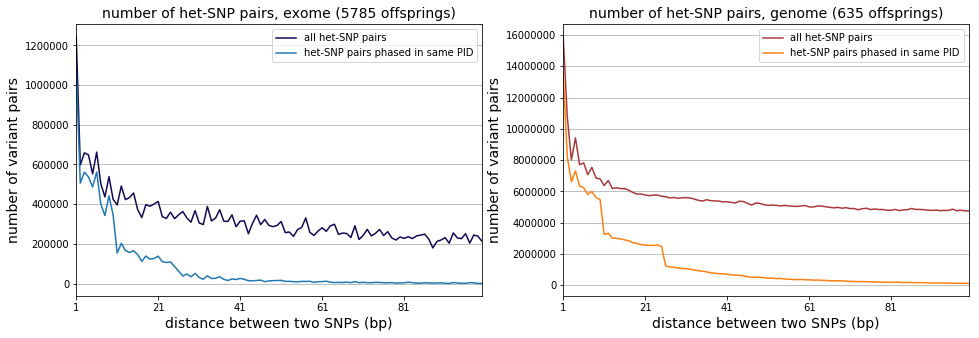

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.ticklabel_format(useOffset=False, style='plain')
d = pd.DataFrame({"all het-SNP pairs":d_ex.loc["n_all",:],"het-SNP pairs phased in same PID":d_ex.loc["n_same_PID",:]})
d.plot(ax=axes[0], color=["#110754ff","#1f77b4ff"])
axes[0].set_xlabel("distance between two SNPs (bp)", fontname = "Microsoft Sans Serif", fontsize=14)
axes[0].set_ylabel("number of variant pairs", fontname = "Microsoft Sans Serif", fontsize=14)
axes[0].set_title("number of het-SNP pairs, exome (5785 offsprings)", fontname = "Microsoft Sans Serif", fontsize=14)
axes[0].grid(axis='y', which="both")
d2 = pd.DataFrame({"all het-SNP pairs":d_gen.loc["n_all",:],"het-SNP pairs phased in same PID":d_gen.loc["n_same_PID",:]})
d2.plot(ax=axes[1], color=["#a93939ff","#ff7f0eff"])
axes[1].set_xlabel("distance between two SNPs (bp)", fontname = "Microsoft Sans Serif", fontsize=14)
axes[1].set_ylabel("number of variant pairs", fontname = "Microsoft Sans Serif", fontsize=14)
axes[1].set_title("number of het-SNP pairs, genome (635 offsprings)", fontname = "Microsoft Sans Serif", fontsize=14)
axes[1].grid(axis='y', which="both")
#took color from https://matplotlib.org/users/dflt_style_changes.html
plt.show()


And let's look at the fraction once more -- we can already imagiine that 

the read based phasing sensitivity and specificity will unfortunately decrease as the distance gets longer than 10 bp 

(And that is one of the reason why we focused on distance <10 bp throughout the research.)

(Supp. Fig. 1)

<Figure size 576x360 with 0 Axes>

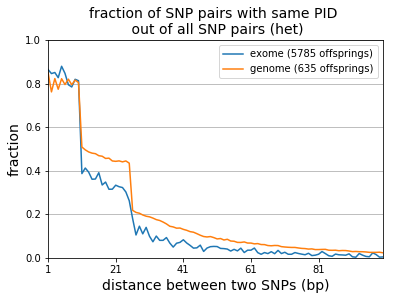

In [14]:
plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = "1"
d_frac = pd.DataFrame({"exome (5785 offsprings)":d_ex.loc["n_same_PID",:]/d_ex.loc["n_all",:]})
d_frac["genome (635 offsprings)"] = d_gen.loc["n_same_PID",:]/d_gen.loc["n_all",:]
d_frac.fillna(0, inplace=True)
ax = d_frac.plot(ylim=[0,1], ) #This looks great
ax.set_xlabel("distance between two SNPs (bp)", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_ylabel("fraction", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_title("fraction of SNP pairs with same PID \n out of all SNP pairs (het)", fontname = "Microsoft Sans Serif", fontsize=14)
plt.grid(axis='y', which="both")
plt.show()


Actually the sensitivity still remains good (For exome the fluctuation is large due to the low number).

We can learn that the HaplotypeCaller is making a relatively conservative call.

<Figure size 576x360 with 0 Axes>

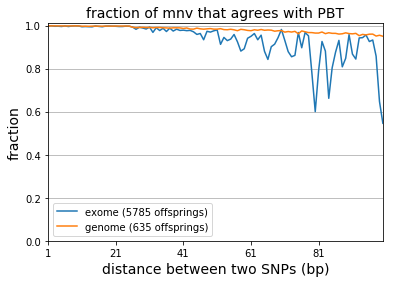

In [16]:
plt.figure(figsize=(8,5))
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = "1"
d_frac = pd.DataFrame({"exome (5785 offsprings)":d_ex.loc["n_mnv_and_agrees_PBT",:]/d_ex.loc["n_mnv_and_has_PBT",:]})
d_frac["genome (635 offsprings)"] = d_gen.loc["n_mnv_and_agrees_PBT",:]/d_gen.loc["n_mnv_and_has_PBT",:]
d_frac.fillna(0, inplace=True)
ax = d_frac.plot(ylim=[0,1.01])
ax.set_xlabel("distance between two SNPs (bp)", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_ylabel("fraction", fontname = "Microsoft Sans Serif", fontsize=14)
ax.set_title("fraction of mnv that agrees with PBT", fontname = "Microsoft Sans Serif", fontsize=14)
plt.grid(axis='y', which="both")
plt.show()


## End notes

- This tutorial showed how to evaluate the phase sensitivity and specificity using trio data that contains both read-based phasing data and trio-based phasing data
- The part of creating the summary information using hail is not described in this tutorial, but users can learn the principles from `sensitivity_proband_full.py` in the code directory.

